In [1]:
from swat import CAS
import swat
from swat.cas.table import merge
import os
import dlpy
import numpy
import matplotlib.image as mping
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from dlpy.images import ImageTable
from dlpy.applications import UNet
from dlpy.model import Optimizer, Model, DataSpec, MomentumSolver, AdamSolver, StepLR
from dlpy.layers import *
from dlpy.utils import display_segmentation_images, create_segmentation_table, display_segmentation_results
from dlpy.sequential import Sequential

In [2]:
conn = CAS("http://172.26.38.241/cas-shared-default-http/", "5570", "sasdemo","sasdemo",caslib="public")
conn.loadactionset('image')
conn.loadactionset('deeplearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deeplearn'.


[actionset]

 'deeplearn'

+ Elapsed: 0.0035s, user: 0.0019s, sys: 0.00158s, mem: 0.212mb

In [3]:
# load_data
image_data = ImageTable.load_files(conn=conn, path='/opt/data/share/data/jupyter/HYF/img', casout=dict(name='data_input'))
image_data = image_data.resize(width=28, height=28, inplace=False)
image_data.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_filename_0,1,varchar,14,14,0,0
1,_image_,2,varbinary,1178,1178,0,0
2,_id_,3,int64,8,12,0,0
3,_label_,4,varchar,0,1,0,0


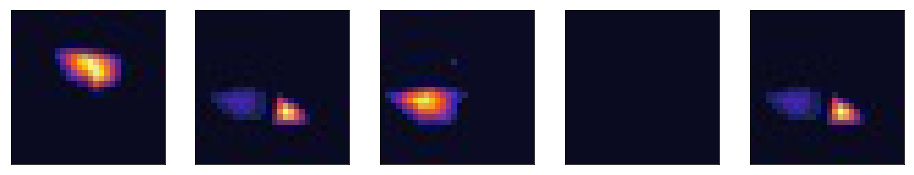

In [4]:
# show inputs
image_data.show()

In [5]:
# auto_encoder model with 28*28*3 inputs. 
# If the width and height change, it is not ensured that the outputs of the model keep the same dimension as the input
data_input = Input(n_channels=3, width=28, height=28, name='Input', scale = 1.0 / 255)
conv_1 = Conv2d(n_filters=16, width=3, height=3, stride=1, padding=1, act='elu')(data_input)
pool_1 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_1)
conv_2 = Conv2d(n_filters=8, width=3, height=3, stride=1, padding=1, act='elu')(pool_1)
pool_1 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_2)
conv_3 = Conv2d(n_filters=8, width=3, height=3, stride=1, padding=1, act='elu')(pool_1)
encoder = Pooling(width=2, height=2, stride=2, padding=1, pool='max', name='encoder')(conv_3)

conv_4 = Conv2d(n_filters=8, width=3, height=3, stride=1, padding=1, act='elu')(encoder)
upsample_1 = Conv2DTranspose(8, 3, padding=1, stride=2, act='relu')(conv_4)
conv_5 = Conv2d(n_filters=8, width=3, height=3, stride=1, padding=1, act='elu')(upsample_1)
upsample_2 = Conv2DTranspose(8, 4, padding=1, stride=2, act='relu')(conv_5)
conv_6 = Conv2d(n_filters=16, width=3, height=3, stride=1, padding=1, act='elu')(upsample_2)
upsample_3 = Conv2DTranspose(16, 4, padding=1, stride=2, act='relu')(conv_6)
decoder = Conv2d(n_filters=3, width=3, height=3, stride=1, padding=1, act='logistic', name='decoder')(upsample_3)

seg1 = Segmentation(name='Segmentation_1', target_scale = 1.0 / 255)(decoder)
model = Model(conn, inputs=data_input, outputs=seg1, model_table='auto_encoder')
model.compile()
model.summary

NOTE: Model compiled successfully.


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,None,Input,input,,,None,"(28, 28, 3)","(0, 0)"
1,None,Conv2d_1,convo,"(3, 3)","(1, 1)",Elu,"(28, 28, 16)","(432, 16)"
2,None,Pooling_1,pool,"(2, 2)","(2, 2)",Max,"(14, 14, 16)","(0, 0)"
3,None,Conv2d_2,convo,"(3, 3)","(1, 1)",Elu,"(14, 14, 8)","(1152, 8)"
4,None,Pooling_2,pool,"(2, 2)","(2, 2)",Max,"(7, 7, 8)","(0, 0)"
5,None,Conv2d_3,convo,"(3, 3)","(1, 1)",Elu,"(7, 7, 8)","(576, 8)"
6,None,encoder,pool,"(2, 2)","(2, 2)",Max,"(4, 4, 8)","(0, 0)"
7,None,Conv2d_4,convo,"(3, 3)","(1, 1)",Elu,"(4, 4, 8)","(576, 8)"
8,None,Conv2DTranspose_1,transconvo,"(3, 3)","(2, 2)",Relu,"(7, 7, 8)","(576, 8)"
9,None,Conv2d_5,convo,"(3, 3)","(1, 1)",Elu,"(7, 7, 8)","(576, 8)"


In [6]:
# fit the model
data_specs = [DataSpec(type_='IMAGE', layer='Input', data=['_image_']),
              DataSpec(type_='IMAGE', layer='Segmentation_1', data_layer='Input')]

solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.00001, step_size=30, gamma=0.8), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=10, log_level=2, max_epochs=100, reg_l2=0.0005, seed=13309)
r = model.fit(data = image_data, data_specs=data_specs, optimizer=optimizer, force_equal_padding=True, n_threads=1)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 10691.
NOTE:  The approximate memory cost is 8.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 10.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 10.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          1E-5             203     0.4059     2.38
NOTE:  1          1E-5           201.1      0.404     2.26
NOTE:  2          1E-5           196.8     0.3994     2.36
NOTE:  3          1E-5           186.2     0.3879    

In [7]:
# get the encoder feature we want
features, images = model.get_features(image_data, 'encoder', target='_image_')
features.shape

(1058, 128)

In [8]:
# check the input and output 
# first get the output table
model.predict(image_data)
result = conn.CASTable(model.valid_res_tbl.name)
result = ImageTable.from_table(result)
conn.table.altertable(columns=[{'rename':'_image_output_', 'name':'_image_'}], name=result)
result.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_output_,1,varbinary,1178,1178,0,0
1,_label_,2,varchar,0,1,0,0
2,_filename_0,3,varchar,14,14,0,0
3,_id_,4,int64,8,12,0,0


In [9]:
# merge the input table and output table in order to do the comparison
conn.deeplearn.dljoin(annotatedtable=image_data, table=result, 
                      casout=dict(name='merged_table', replace=True), id='_filename_0')
merged_table = conn.CASTable('merged_table')
merged_table.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_filename_0,1,varchar,14,14,0,0
1,_image_output_,2,varbinary,1178,1178,0,0
2,_label_,3,varchar,0,1,0,0
3,_id_,4,int64,8,12,0,0
4,_image_,5,varbinary,1178,1178,0,0


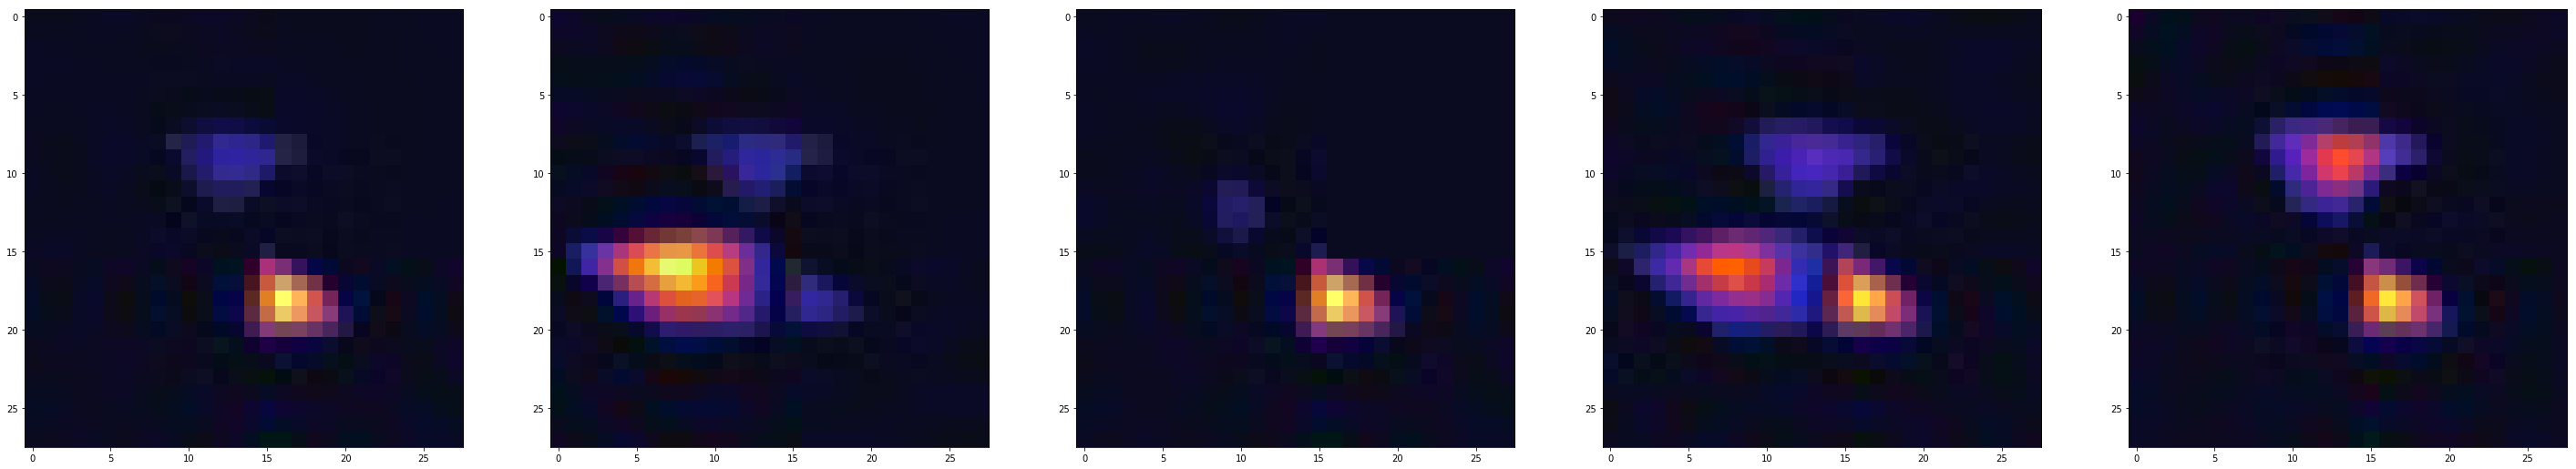

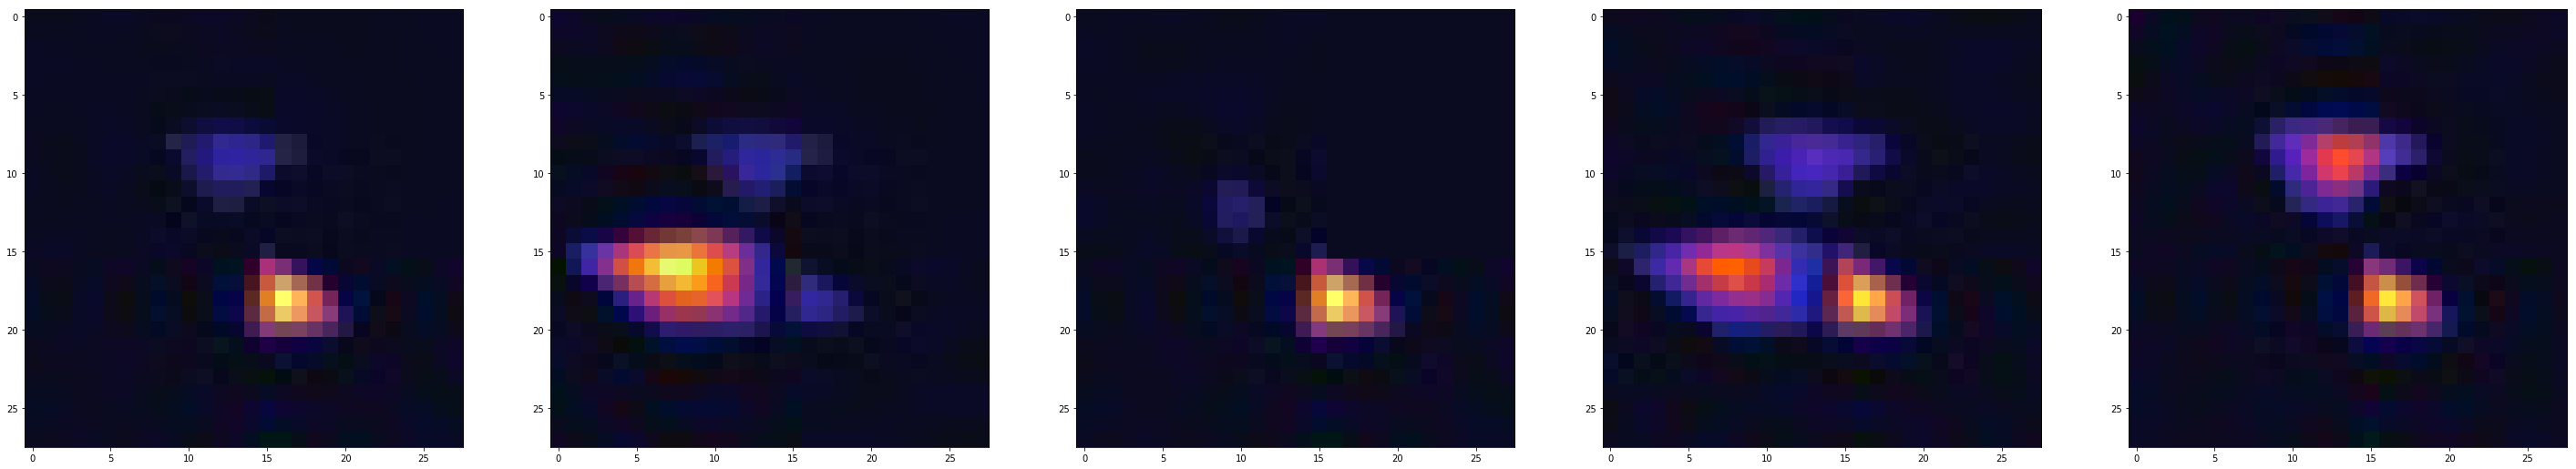

In [14]:
# I only find this way to do the comparison
display_segmentation_images(conn, 'merged_table', n_images=5, image_column='_image_', 
                            segmentation_labels_table='merged_table', label_column='_label_')

display_segmentation_images(conn, 'merged_table', n_images=5, image_column='_image_output_', 
                            segmentation_labels_table='merged_table', label_column='_label_')

In [15]:
conn.close()